# Figures S16b

This notebook loads the data and produces figure S16b.

In [1]:
plotsavedate = '20251031'

In [2]:
data_path = '' # path to data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import statsmodels.api as sm
import copy
DC_STATEHOOD=True
import us

# Load and Compile Data

In [4]:
# Load data
df_bg_level = pd.read_csv(data_path + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

# Gini coefficient for each state
tmp0 = df_bg_level.groupby('STATEFP')[['Gini_state']].mean().reset_index()

# Cluster counts
cluster_cols =['no_stations_k8_University_college_campuses', 'no_stations_k8_Weekday_daytime_short_stops', 'no_stations_k8_City_neighborhoods', 'no_stations_k8_Weekday_daytime_long_stops', 'no_stations_k8_Gas_stations_very_short_stops', 'no_stations_k8_Weekend_evening_recreation', 'no_stations_k8_High_density_city', 'no_stations_k8_Hotels']
df_clust = df_bg_level.groupby('STATEFP')[cluster_cols].sum().reset_index()
 
# Combine
df_plot = df_clust.merge(tmp0[['STATEFP', 'Gini_state']], on='STATEFP', how='outer')

# Cluster shares
for col in cluster_cols:
    df_plot.loc[:, col+'_share'] = df_plot.loc[:, col] / df_plot.loc[:, cluster_cols].sum(axis=1)

# Plotting

In [5]:
label_mapping = {}
label_mapping['Column Names'] = {0:'University_college_campuses', 
                  1:'Weekday_daytime_short_stops', 
                  2:'City_neighborhoods', 
                  3:'Weekday_daytime_long_stops', 
                  4:'Gas_stations_very_short_stops', 
                  5:'Weekend_evening_recreation', 
                  6:'High_density_city', 
                  7:'Hotels'}


label_mapping['Nice Names'] = {0:'University/college campuses',
                               1:'Weekday daytime short stops',
                               2:'City neighborhoods',
                               3:'Weekday daytime long stops',
                               4:'Gas station very short stops',
                               5:'Weekend evening recreation',
                               6:'City destinations',
                               7:'Hotels'}

colours_dict8_v3 = {1:'#006837',
                    3:'#1a9850',
                    5:'#a6d96a',
                    2:'#fdae61',
                    6:'#f46d43',
                    7:'#cb181d',
                    4:'#df65b0',
                   0:'#8073ac'}

cluster_order_numbers8_v3 = [1, 3, 5, 2, 6, 7, 4, 0]
cluster_order_dict = {i:j for i, j in enumerate(cluster_order_numbers8_v3)}
cluster_order_names = [label_mapping['Column Names'][i] for i in cluster_order_numbers8_v3]
cluster_cols = ['no_stations_k8_'+label_mapping['Column Names'][key] for key in range(8)]

In [6]:
def stars(pval):
    if pval < 0.05:
        if pval < 0.01:
            if pval < 0.001:
                return "***"
            else:
                return "**"
        else:
            return '*'
    else:
        return ''

# Figure S15 b

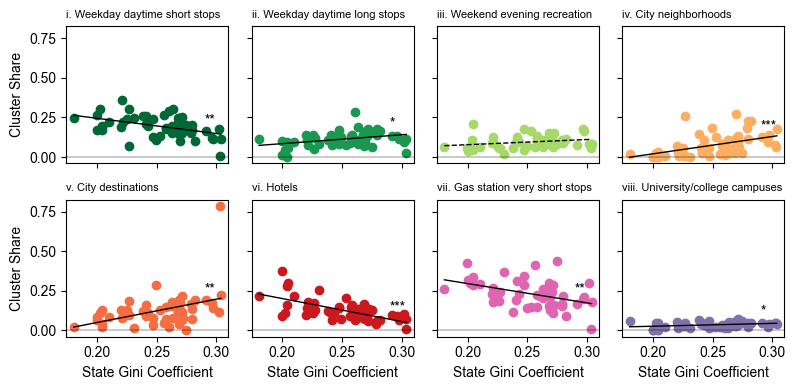

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)

xcol = 'Gini_state'
xcol_nice = 'State Gini Coefficient'
counter = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii']

for row in range(2):
    for column in range(4):
        
        cluster = cluster_cols[cluster_order_numbers8_v3[row*4+column]]
        
        axes[row, column].scatter(df_plot[xcol], df_plot[cluster+'_share'], c=colours_dict8_v3[cluster_order_dict[row*4+column]])
        axes[row, column].set_title(counter[row*4+column] + '. '+label_mapping['Nice Names'][cluster_order_numbers8_v3[row*4+column]], fontsize=8, loc='left')#cluster[15:], fontsize=8)
        
        if row == 1:
            axes[row, column].set_xlabel(xcol_nice)
        if column == 0:
            axes[row, column].set_ylabel('Cluster Share')
            
            
        X = df_plot[df_plot.isna().sum(axis=1) == 0][xcol].values
        X = sm.add_constant(X)
        y = df_plot[df_plot.isna().sum(axis=1) == 0][cluster+'_share'].values
        model = sm.OLS(y, X).fit()

        if model.pvalues[1] < 0.05:
            xvals = df_plot[df_plot.isna().sum(axis=1) == 0][xcol].values
            axes[row, column].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color='k', linewidth=1)
            axes[row, column].annotate(stars(model.pvalues[1]), (0.29, (model.params[0] + model.params[1]*0.29)+0.05))
        else:
            xvals = df_plot[df_plot.isna().sum(axis=1) == 0][xcol].values
            axes[row, column].plot(np.sort(xvals), model.params[0] + model.params[1]*np.sort(xvals), color='k', linestyle='--', linewidth=1)
            
        axes[row, column].axhline(0, linewidth=0.3, color='k')
    
plt.tight_layout()
plt.savefig('Figures/figureS16b_gini_clusters_'+plotsavedate+'.pdf', bbox_inches='tight')
plt.savefig('Figures/figureS16b_gini_clusters_'+plotsavedate+'.png', bbox_inches='tight', dpi=400)
plt.show()    